In [1]:
!pip install einops
!pip install fancy_einsum
from typing import Optional, Union, Iterator, cast, TypeVar, Generic, Callable, Any
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
import torch as t
import torchvision
from einops import rearrange, repeat, reduce
from fancy_einsum import einsum
from torch import nn
import os
from IPython.display import display
from PIL import Image
from scipy import linalg
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchvision.transforms import CenterCrop, Compose, Lambda, RandomHorizontalFlip, Resize, ToPILImage, ToTensor
from tqdm.auto import tqdm

from pathlib import Path
import logging
import wandb
import numpy as np
import time
from functools import wraps

  Obtaining dependency information for einops from https://files.pythonhosted.org/packages/29/0b/2d1c0ebfd092e25935b86509a9a817159212d82aa43d7fb07eca4eeff2c2/einops-0.7.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.2 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

def allclose(actual: t.Tensor, expected: t.Tensor, rtol=1e-4) -> None:
    assert_shape_equal(actual, expected)
    left = (actual - expected).abs()
    right = rtol * expected.abs()
    num_wrong = (left > right).sum().item()
    if num_wrong > 0:
        print(f"Test failed. Max absolute deviation: {left.max()}")
        print(f"Actual:\n{actual}\nExpected:\n{expected}")
        raise AssertionError(f"allclose failed with {num_wrong} / {left.nelement()} entries outside tolerance")
    elif DEBUG_TOLERANCES:
        print(f"Test passed with max absolute deviation of {left.max()}")
        
TEST_FN_PASSED = {}
DEBUG_TOLERANCES = os.getenv("DEBUG_TOLERANCES")


def report_success(testname):
    """POST to the server indicating success at the given test.

    Used to help the TAs know how long each section takes to complete.
    """
    server = os.environ.get("MLAB_SERVER")
    email = os.environ.get("MLAB_EMAIL")
    if server:
        if email:
            r = requests.post(
                server + "/api/report_success",
                json=dict(email=email, testname=testname),
            )
            if r.status_code != http.HTTPStatus.NO_CONTENT:
                raise ValueError(f"Got status code from server: {r.status_code}")
        else:
            raise ValueError(f"Server set to {server} but no MLAB_EMAIL set!")
    else:
        if email:
            raise ValueError(f"Email set to {email} but no MLAB_SERVER set!")
        else:
            return  # local dev, do nothing
        
def report(test_func):
    name = f"{test_func.__module__}.{test_func.__name__}"
    # This can happen when using autoreload, so don't complain about it.
    # if name in TEST_FN_PASSED:
    #     raise KeyError(f"Already registered: {name}")
    TEST_FN_PASSED[name] = False

    @wraps(test_func)
    def wrapper(*args, **kwargs):
        return run_and_report(test_func, name, *args, **kwargs)

    return wrapper

def run_and_report(test_func: Callable, name: str, *test_func_args, **test_func_kwargs):
    start = time.time()
    out = test_func(*test_func_args, **test_func_kwargs)
    elapsed = time.time() - start
    print(f"{name} passed in {elapsed:.2f}s.")
    if not TEST_FN_PASSED.get(name):
        report_success(name)
        TEST_FN_PASSED[name] = True
    return out

def assert_shape_equal(actual: t.Tensor, expected: t.Tensor) -> None:
    if actual.shape != expected.shape:
        raise AssertionError(f"expected shape={expected.shape}, got {actual.shape}")
        

@t.inference_mode()
@report
def test_groupnorm(GroupNorm, affine: bool):
    if not affine:
        x = t.arange(72, dtype=t.float32).view(3, 6, 2, 2)
        ref = t.nn.GroupNorm(num_groups=3, num_channels=6, affine=False)
        expected = ref(x)
        gn = GroupNorm(num_groups=3, num_channels=6, affine=False)
        actual = gn(x)
        allclose(actual, expected)

    else:
        t.manual_seed(776)
        x = t.randn((3, 6, 8, 10), dtype=t.float32)
        ref = t.nn.GroupNorm(num_groups=3, num_channels=6, affine=True)
        expected = ref(x)
        gn = GroupNorm(num_groups=3, num_channels=6, affine=True)
        gn.weight.copy_(ref.weight)
        gn.bias.copy_(ref.bias)
        actual = gn(x)
        allclose(actual, expected)
        
@t.inference_mode()
@report
def test_self_attention(SelfAttention):
    channels = 16
    img = t.randn(1, channels, 64, 64)
    sa = SelfAttention(channels=channels, num_heads=4)
    out = sa(img)
    assert out.shape == img.shape
    
@t.inference_mode()
@report
def test_attention_block(AttentionBlock):
    ab = AttentionBlock(channels=16)
    img = t.randn(1, 16, 64, 64)
    out = ab(img)
    assert out.shape == img.shape
    
@t.inference_mode()
@report
def test_residual_block(ResidualBlock):
    in_channels = 6
    out_channels = 10
    step_dim = 1000
    groups = 2
    time_emb = t.randn(1, 1000)
    img = t.randn(1, in_channels, 32, 32)
    rb = ResidualBlock(in_channels, out_channels, step_dim, groups)
    out = rb(img, time_emb)
    assert out.shape == (1, out_channels, 32, 32)
    
@t.inference_mode()
@report
def test_downblock(DownBlock, downsample: bool):
    in_channels = 8
    out_channels = 12
    time_emb_dim = 1000
    groups = 2
    time_emb = t.randn(1, 1000)
    img = t.randn(1, in_channels, 32, 32)
    db = DownBlock(in_channels, out_channels, time_emb_dim, groups, downsample)
    out, skip = db(img, time_emb)
    assert skip.shape == (1, out_channels, 32, 32)
    if downsample:
        assert out.shape == (1, out_channels, 16, 16)
    else:
        assert out.shape == (1, out_channels, 32, 32)
        
@t.inference_mode()
@report
def test_upblock(UpBlock, upsample):
    in_channels = 8
    out_channels = 12
    time_emb_dim = 1000
    groups = 2
    time_emb = t.randn(1, 1000)
    img = t.randn(1, out_channels, 16, 16)
    skip = t.rand_like(img)
    up = UpBlock(in_channels, out_channels, time_emb_dim, groups, upsample)
    out = up(img, time_emb, skip)
    if upsample:
        assert out.shape == (1, in_channels, 32, 32)
    else:
        assert out.shape == (1, in_channels, 16, 16)
        
@t.inference_mode()
@report
def test_midblock(MidBlock):
    mid_channels = 8
    time_emb_dim = 1000
    groups = 2
    time_emb = t.randn(1, 1000)
    img = t.randn(1, mid_channels, 32, 32)
    mid = MidBlock(mid_channels, time_emb_dim, groups)
    out = mid(img, time_emb)
    assert out.shape == (1, mid_channels, 32, 32)
    
@t.inference_mode()
@report
def test_unet(Unet):
    # dim mults is limited by number of multiples of 2 in the image
    # 28 -> 14 -> 7 is ok but can't half again without having to deal with padding
    image_size = 28
    channels = 8
    batch_size = 8
    model = Unet(
        image_shape=(8, 28, 28),
        channels=channels,
        dim_mults=(
            1,
            2,
            4,
        ),
    )
    x = t.randn((batch_size, channels, image_size, image_size))
    num_steps = t.randint(0, 1000, (batch_size,))
    out = model(x, num_steps)
    assert out.shape == x.shape

In [3]:


def linear_schedule(max_steps: int, min_noise: float = 0.0001, 
                   max_noise: float = 0.02) -> t.Tensor:
    """Return the forward process variances as in the paper.

    max_steps: total number of steps of noise addition
    out: shape (step=max_steps, ) the amount of noise at each step
    """
    return t.linspace(min_noise, max_noise, max_steps)

betas = linear_schedule(max_steps = 200)


class NoiseSchedule(nn.Module):
    betas: t.Tensor
    alphas: t.Tensor
    alpha_bars: t.Tensor

    def __init__(self, max_steps: int, device: Union[t.device, str]) -> None:
        super().__init__()
        self.max_steps = max_steps
        self.device = device
        self.register_buffer("betas", linear_schedule(max_steps))
        alphas = 1 - self.betas
        self.register_buffer("alphas", alphas)
        alpha_bars = t.cumprod(alphas, dim=-1)
        self.register_buffer("alpha_bars", alpha_bars)
        self.to(device)

    @t.inference_mode()
    def beta(self, num_steps: Union[int, t.Tensor]) -> t.Tensor:
        """
        Returns the beta(s) corresponding to a given number of noise steps
        num_steps: int or int tensor of shape (batch_size,)
        Returns a tensor of shape (batch_size,), where batch_size is one if num_steps is an int
        """
        return self.betas[num_steps]

    @t.inference_mode()
    def alpha(self, num_steps: Union[int, t.Tensor]) -> t.Tensor:
        """
        Returns the alphas(s) corresponding to a given number of noise steps
        num_steps: int or int tensor of shape (batch_size,)
        Returns a tensor of shape (batch_size,), where batch_size is one if num_steps is an int
        """
        return self.alphas[num_steps]

    @t.inference_mode()
    def alpha_bar(self, num_steps: Union[int, t.Tensor]) -> t.Tensor:
        """
        Returns the alpha_bar(s) corresponding to a given number of noise steps
        num_steps: int or int tensor of shape (batch_size,)
        Returns a tensor of shape (batch_size,), where batch_size is one if num_steps is an int
        """
        return self.alpha_bars[num_steps]

    def __len__(self) -> int:
        return self.max_steps

class DiffusionModel(nn.Module, ABC):
    img_shape: tuple[int, ...]
    noise_schedule: Optional[NoiseSchedule]
    
    @abstractmethod
    def forward(self, images: t.Tensor, num_steps: t.Tensor) -> t.Tensor:
        ...
        

def train(
    model: DiffusionModel, config_dict: dict[str, Any],
    trainset: TensorDataset, testset: Optional[TensorDataset] = None
) -> DiffusionModel:
    wandb.init(project = "diffusion_models", config = config_dict,
              job_type = "train",
              group = "part1")
    config = wandb.config
    print(f"Training with config: {config}")
    schedule = NoiseSchedule(config.max_steps, config.device)
    model.noise_schedule = schedule
    model.to(config.device)
    model.train()
    optimizer = t.optim.Adam(model.parameters(), lr = config.lr)
    train_loader = DataLoader(trainset, batch_size = config.batch_size,
                             shuffle = True)
    if testset is not None:
        test_loader = DataLoader(testset, batch_size = config.batch_size)
    
    start_time = time.time()
    examples_seen = 0
    for epoch in range(config.epochs):
        for i, (x,) in enumerate(tqdm(train_loader, desc = f"Epoch {epoch + 1}")):
            x = x.to(config.device)
            num_steps, noise, noised = noise_img(x, schedule)
            y_hat = model(noised, num_steps)
            loss = F.mse_loss(y_hat, noise)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            info: dict[str, Any] = dict(
                train_loss = loss,
                elapsed = time.time() - start_time,
                y_hat_mean = y_hat.mean(),
                y_hat_var = y_hat.var(),
                noised_mean = noised.mean(),
                noised_var = noised.var(),
            )
            
            if (i + 1) % config.img_log_interval == 0:
                reconstructed = reconstruct(noised, y_hat, num_steps, schedule)
                info["images"] = log_images(
                    img = x,
                    noised = noised,
                    noise = noise,
                    noise_pred = y_hat,
                    reconstructed = reconstructed,
                    num_images = config.n_images_to_log,
                    
                )
            examples_seen += len(x)
            wandb.log(info, step=examples_seen)
            
        if testset is not None:
            losses = []
            for i, (x,) in enumerate(tqdm(test_loader, desc = f"Eval for Epoch {epoch + 1}")):
                x = x.to(config.device)
                num_steps, noise, noised = noise_img(x, schedule)
                with t.inference_mode():
                    y_hat = model(noised, num_steps)
                    loss = F.mse_loss(y_hat, noise)
                losses.append(loss.item())
            eval_info = dict(eval_loss = sum(losses) / len(losses))
            wandb.log(eval_info, step = examples_seen)
        
    wandb.finish()
    return model

def sample(model: DiffusionModel, n_samples: int, return_all_steps: bool = False) -> Union[t.Tensor, list[t.Tensor]]:
    """
    Sample, following Algorithm 2 in the DDPM paper

    model: The trained noise-predictor
    n_samples: The number of samples to generate
    return_all_steps: if true, return a list of the reconstructed tensors generated at each step, rather than just the final reconstructed image tensor.

    out: shape (B, C, H, W), the denoised images
    """
    schedule = model.noise_schedule
    if return_all_steps:
        all_steps: list[t.Tensor] = []
            
    shape = (n_samples, *model.img_shape)
    B, C, H, W = shape
    Xt = t.randn(shape, device=schedule.device)
    if return_all_steps:
        all_steps.append(Xt.cpu().clone())
    model.eval()
    
    for step in tqdm(reversed(range(0, len(schedule))), total = len(schedule)):
        num_steps = t.full((n_samples,), fill_value=step, device=schedule.device)
        if step > 1:
            sigma = schedule.beta(step).sqrt()
            noise = sigma * t.randn_like(Xt)
        else:
            noise = 0
        
        pred = model(Xt, num_steps)
        pred_scale = schedule.beta(step) / t.sqrt(1 - schedule.alpha_bar(step))
        denoised_scale = 1 / (t.sqrt(schedule.alpha(step)))
        Xt = denoised_scale * (Xt - pred_scale * pred) + noise
        
        if return_all_steps:
            all_steps.append(Xt.cpu().clone())
            
    if return_all_steps:
        return all_steps
    return Xt

def noise_img(
    img: t.Tensor, noise_schedule: NoiseSchedule, max_steps: Optional[int] = None
) -> tuple[t.Tensor, t.Tensor, t.Tensor]:
    """
    Adds a random number of steps of noise to each image in img.

    img: An image tensor of shape (B, C, H, W)
    noise_schedule: The NoiseSchedule to follow
    max_steps: if provided, only perform the first max_steps of the schedule

    Returns a tuple composed of:
    num_steps: an int tensor of shape (B,) of the number of steps of noise added to each image
    noise: the unscaled, standard Gaussian noise added to each image, a tensor of shape (B, C, H, W)
    noised: the final noised image, a tensor of shape (B, C, H, W)
    """
    B, C, H, W = img.shape
    """SOLUTION"""
    if max_steps is None:
        max_steps = len(noise_schedule)
    assert len(noise_schedule) >= max_steps
    num_steps = t.randint(1, max_steps, size=(B,), device=img.device)
    noise = t.randn_like(img)
    x_scale = noise_schedule.alpha_bar(num_steps).sqrt()
    noise_scale = (1 - noise_schedule.alpha_bar(num_steps)).sqrt()
    noised = (
        repeat(x_scale, "b -> b c h w", c=C, h=H, w=W) * img
        + repeat(noise_scale, "b -> b c h w", c=C, h=H, w=W) * noise
    )
    return num_steps, noise, noised

def reconstruct(
    noisy_img: t.Tensor,
    noise: t.Tensor,
    num_steps: t.Tensor,
    noise_schedule: NoiseSchedule,
) -> t.Tensor:
    """
    Subtract the scaled noise from noisy_img to recover the original image. We'll later use this with the model's output to log reconstructions during training. We'll use a different method to sample images once the model is trained.

    Returns img, a tensor with shape (B, C, H, W)
    """
    B, C, H, W = noisy_img.shape
    x_scale = noise_schedule.alpha_bar(num_steps).sqrt()
    noise_scale = (1 - noise_schedule.alpha_bar(num_steps)).sqrt()
    img = noisy_img - repeat(noise_scale, "b -> b c h w", c=C, h=H, w=W) * noise
    img = img / repeat(x_scale, "b -> b c h w", c=C, h=H, w=W)
    assert img.shape == (B, C, H, W)
    return img

def log_images(
    img: t.Tensor, noised: t.Tensor, noise: t.Tensor, noise_pred: t.Tensor,
    reconstructed: t.Tensor, num_images: int
) -> list[wandb.Image]:
    """
    Convert tensors to a format suitable for logging to Weights and Biases. Returns an image with the ground truth in the upper row, and model reconstruction on the bottom row. Left is the noised image, middle is noise, and reconstructed image is in the rightmost column.
    """
    actual = t.cat((noised, noise, img), dim = -1)
    pred = t.cat((noised, noise_pred, reconstructed), dim = -1)
    log_img = t.cat((actual, pred), dim = -2)
    images = [wandb.Image(i) for i in log_img[:num_images]]
    return images

In [4]:
class GroupNorm(nn.Module):
    def __init__(
        self,
        num_groups: int,
        num_channels: int,
        eps: float = 1e-05,
        affine: bool = True,
        device: Optional[Union[t.device, str]] = None,
        dtype: Optional[t.dtype] = None,
    ) -> None:
        
        super().__init__()
        assert num_channels % num_groups == 0
        self.num_groups = num_groups
        self.num_channels = num_channels
        self.eps = eps
        self.affine = affine
        self.dtype = dtype
        if self.affine:
            self.weight = nn.Parameter(t.empty((self.num_channels,), device = device, dtype = dtype))
            self.bias = nn.Parameter(t.empty((self.num_channels,), device = device, dtype = dtype))
        else:
            self.register_parameter("weight", None)
            self.register_parameter("bias", None)
        self.reset_parameters()
    
    def reset_parameters(self) -> None:
        """Initialize the weight and bias, if applicable."""
        if self.affine:
            nn.init.ones_(self.weight)
            nn.init.zeros_(self.bias)
    
    def forward(self, x: t.Tensor) -> t.Tensor:
        """Apply normalization to each group of channels.

        x: shape (batch, channels, height, width)
        out: shape (batch, channels, height, width)
        """
        x = rearrange(x, "b (g c) h w -> b g c h w", g = self.num_groups)
        mean_dim = (2, 3, 4)
        mean = x.mean(dim = mean_dim, keepdim = True)
        var = x.var(dim = mean_dim, keepdim = True, unbiased = False)
        x = x - mean
        x = x / (var + self.eps) ** 0.5
        x = rearrange(x, "b g c h w -> b (g c) h w")
        if self.affine:
            x = x * self.weight.view(1, -1, 1, 1)
            x = x + self.bias.view(1, -1, 1, 1)
        return x

test_groupnorm(GroupNorm, affine=False)
test_groupnorm(GroupNorm, affine=True)

__main__.test_groupnorm passed in 1.57s.
__main__.test_groupnorm passed in 0.01s.


[Text(0.5, 0, 'Num Steps'),
 Text(0, 0.5, 'Num Steps'),
 Text(0.5, 1.0, 'Dot product of position embeddings')]

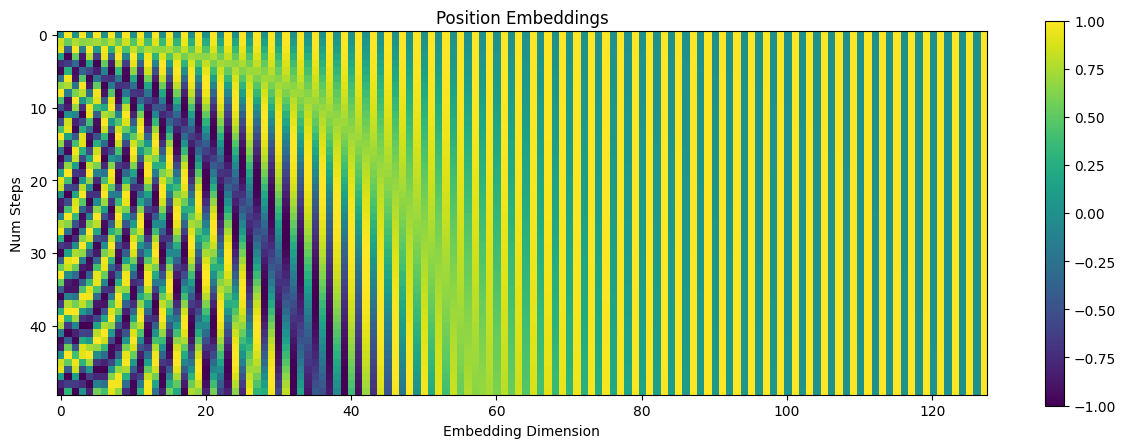

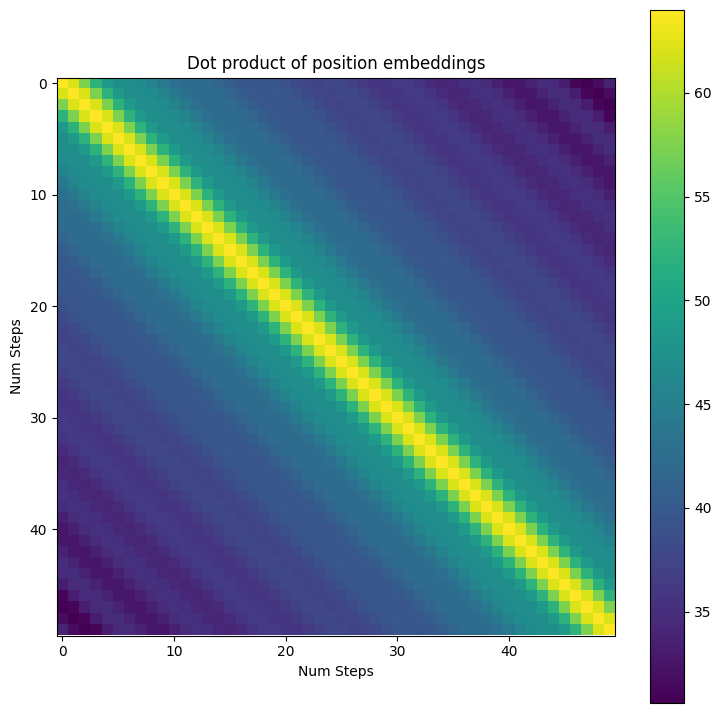

In [5]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, embedding_size: int):
        super().__init__()
        self.embedding_size = embedding_size
        wk = 1.0 / 10000.0 ** ((t.arange(0, embedding_size, 2)) / embedding_size)
        self.register_buffer("wk", wk)
        
    
    def forward(self, x: t.Tensor) -> t.Tensor:
        """
        x: shape (batch, ) - for each batch element, the number of noise steps
        Out: shape (batch, embedding_size)
        """
        wkx = t.einsum("x, w -> xw", x, self.wk)
        stacked = t.stack((wkx.sin(), wkx.cos()), dim = -1)
        flat = rearrange(stacked, "batch k func -> batch (k func)", func = 2)
        return flat
    

emb = SinusoidalPositionEmbeddings(128)
out = emb(t.arange(50))
fig, ax = plt.subplots(figsize=(15, 5))
ax.set(xlabel="Embedding Dimension", ylabel="Num Steps", title="Position Embeddings")
im = ax.imshow(out, vmin = -1, vmax = 1)
fig.colorbar(im)

fig, ax = plt.subplots(figsize=(9, 9))
im = ax.imshow(out @ out.T)
fig.colorbar(im)
ax.set(xlabel="Num Steps", ylabel="Num Steps", title="Dot product of position embeddings")

[Text(0.5, 0, 'x'), Text(0, 0.5, 'swish(x)')]

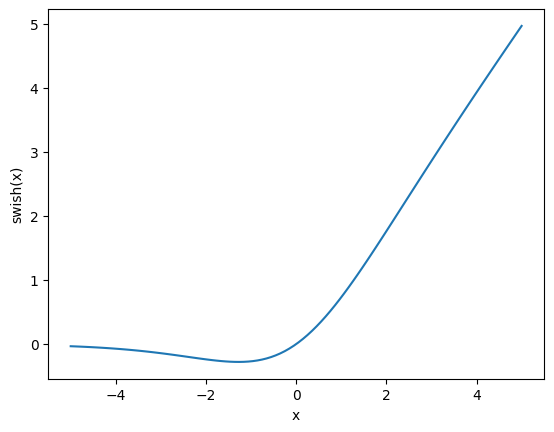

In [6]:
def swish(x: t.Tensor) -> t.Tensor:
    return x * x.sigmoid()

class SiLU(nn.Module):
    def forward(self, x: t.Tensor) -> t.Tensor:
        return swish(x)
    
x = t.linspace(-5, 5, 100)
fig, ax = plt.subplots()
ax.plot(x, swish(x))
ax.set(xlabel="x", ylabel="swish(x)")


In [7]:
class SelfAttention(nn.Module):
    def __init__(self, channels: int, num_heads: int = 4):
        """Self-Attention with two spatial dimensions.

        channels: the number of channels. Should be divisible by the number of heads.
        """
        super().__init__()
        self.num_heads = num_heads
        self.num_channels = channels
        assert channels % num_heads == 0
        self.head_size = channels // num_heads
        self.in_proj = nn.Linear(channels, channels * 3)
        self.out_proj = nn.Linear(channels, channels)

    def forward(self, x: t.Tensor) -> t.Tensor:
        """
        x: shape (batch, channels, height, width)
        out: shape (batch, channels, height, width)
        """
        b, c, h, w = x.shape
        assert self.num_channels == c
        x = rearrange(x, "b c h w -> b (h w) c")
        qkv = self.in_proj(x).chunk(3, dim = -1)
        q, k, v = [rearrange(tensor, "batch seq (head head_size) -> batch head seq head_size",
                  head = self.num_heads)
                   for tensor in qkv
                  ]
        out = einsum('b head seq_q head_size, b head seq_k head_size -> b head seq_q seq_k', q, k)
        out = out / (self.head_size ** 0.5)
        attn = out.softmax(dim = -1)
        out = einsum("batch head seq_k head_size, batch head seq_q seq_k -> batch head seq_q head_size", v, attn)
        out = rearrange(out, "batch head seq head_size -> batch seq (head head_size)")
        out = self.out_proj(out)
        out = rearrange(out, "batch (height width) channels -> batch channels height width",
                       height = h, width = w)
        return out
    
test_self_attention(SelfAttention)

__main__.test_self_attention passed in 0.53s.


In [8]:
class AttentionBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.channels = channels
        self.n_groups = 1
        self.n_heads = 4
        self.group_norm_block = GroupNorm(self.n_groups, channels)
        self.sa_block = SelfAttention(channels, self.n_heads)

    def forward(self, x: t.Tensor) -> t.Tensor:
        img = x
        x = self.group_norm_block(x)
        x = self.sa_block(x)
        return x + img
    
test_attention_block(AttentionBlock)

class ResidualBlock(nn.Module):
    def __init__(self, input_channels: int, output_channels: int, step_dim: int, groups: int):
        """
        input_channels: number of channels in the input to foward
        output_channels: number of channels in the returned output
        step_dim: embedding dimension size for the number of steps
        groups: number of groups in the GroupNorms

        Note that the conv in the left branch is needed if c_in != c_out.
        """
        super().__init__()
        self.c_in_h = input_channels
        self.c_out_h = output_channels
        self.step_dim = step_dim
        self.groups = groups
        self.mlp = nn.Sequential(
            SiLU(),
            nn.Linear(self.step_dim, self.c_out_h)
        )
        self.block1 = nn.Sequential(
            nn.Conv2d(self.c_in_h, self.c_out_h, 3, padding = 1),
            GroupNorm(self.groups, self.c_out_h),
            SiLU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(self.c_out_h, self.c_out_h, 3, padding = 1),
            GroupNorm(self.groups, self.c_out_h),
            SiLU()
        )
        self.res_conv = nn.Sequential(
            nn.Conv2d(self.c_in_h, self.c_out_h, 1) if self.c_in_h != self.c_out_h else nn.Identity()
        )
        

    def forward(self, x: t.Tensor, time_emb: t.Tensor) -> t.Tensor:
        """
        Note that the output of the (silu, linear) block should be of shape (batch, c_out). Since we would like to add this to the output of the first (conv, norm, silu) block, which will have a different shape, we need to first add extra dimensions to the output of the (silu, linear) block.
        """
        h = self.block1(x)
        h = rearrange(self.mlp(time_emb), "b c -> b c 1 1") + h
        h = self.block2(h)
        return self.res_conv(x) + h

test_residual_block(ResidualBlock)

class DownBlock(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, time_emb_dim: int, groups: int, downsample: bool):
        super().__init__()
        self.c_in = channels_in
        self.c_out = channels_out
        self.time_emb_dim = time_emb_dim
        self.n_groups = groups
        self.downsample = downsample
        self.res_block1 = ResidualBlock(self.c_in, self.c_out, self.time_emb_dim, self.n_groups)
        self.res_block2 = ResidualBlock(self.c_out, self.c_out, self.time_emb_dim, self.n_groups)
        self.attn_block = AttentionBlock(self.c_out)
        self.block3 = nn.Conv2d(self.c_out, self.c_out, 4, 2, 1) if self.downsample else nn.Identity()

    def forward(self, x: t.Tensor, step_emb: t.Tensor) -> tuple[t.Tensor, t.Tensor]:
        """
        x: shape (batch, channels, height, width)
        step_emb: shape (batch, emb)
        Return: (downsampled output, full size output to skip to matching UpBlock)
        """
        b, c, h, w = x.shape
        x = self.res_block1(x, step_emb)
        x = self.res_block2(x, step_emb)
        skip = self.attn_block(x)
        if self.downsample:
            assert h % 2 == 0 and w % 2 == 0
        x = self.block3(x)
        return x, skip        
    
test_downblock(DownBlock, downsample=True)
test_downblock(DownBlock, downsample=False)

class UpBlock(nn.Module):
    def __init__(self, dim_in: int, dim_out: int, time_emb_dim: int, groups: int, upsample: bool):
        """
        IMPORTANT: arguments are with respect to the matching DownBlock.

        """
        super().__init__()
        self.c_in = dim_in
        self.c_out = dim_out
        self.emb = time_emb_dim
        self.n_groups = groups
        self.upsample = upsample
        
        self.res_block1 = ResidualBlock(2 * self.c_out, self.c_in, self.emb,
                                       self.n_groups)
        self.res_block2 = ResidualBlock(self.c_in, self.c_in, self.emb,
                                       self.n_groups)
        self.attn_block = AttentionBlock(self.c_in)
        self.conv_transpose = nn.ConvTranspose2d(self.c_in, self.c_in, 4, 2, 1) if self.upsample else nn.Identity()

    def forward(self, x: t.Tensor, step_emb: t.Tensor, skip: t.Tensor) -> t.Tensor:
        """ """
        in_concat = t.cat([skip, x], dim = 1)
        x = self.res_block1(in_concat, step_emb)
        x = self.res_block2(x, step_emb)
        x = self.attn_block(x)
        x = self.conv_transpose(x)
        return x
    
test_upblock(UpBlock, upsample=True)
test_upblock(UpBlock, upsample=False)

class MidBlock(nn.Module):
    def __init__(self, mid_dim: int, time_emb_dim: int, groups: int):
        super().__init__()
        self.c_mid = mid_dim
        self.emb = time_emb_dim
        self.n_groups = groups
        self.res_block1 = ResidualBlock(self.c_mid, self.c_mid,
                                       self.emb, self.n_groups)
        self.res_block2 = ResidualBlock(self.c_mid, self.c_mid,
                                       self.emb, self.n_groups)
        self.attn_block = AttentionBlock(self.c_mid)
        

    def forward(self, x: t.Tensor, step_emb: t.Tensor):
        x = self.res_block1(x, step_emb)
        x = self.attn_block(x)
        x = self.res_block2(x, step_emb)
        return x
    
test_midblock(MidBlock)



class Unet(DiffusionModel):
    def __init__(
        self,
        image_shape: tuple[int, int, int],
        channels: int = 128,
        dim_mults: tuple[int, ...] = (1, 2, 4, 8),
        groups: int = 4,
        max_steps: int = 1000,
    ):
        """
        image_shape: the input and output image shape, a tuple of (C, H, W)
        channels: the number of channels after the first convolution.
        dim_mults: the number of output channels for downblock i is dim_mults[i] * channels. Note that the default arg of (1, 2, 4, 8) will contain one more DownBlock and UpBlock than the DDPM image above.
        groups: number of groups in the group normalization of each ResnetBlock (doesn't apply to attention block)
        max_steps: the max number of (de)noising steps. We also use this value as the sinusoidal positional embedding dimension (although in general these do not need to be related).
        """
        super().__init__()
        self.noise_schedule = None
        self.img_shape = image_shape
        self.n_channels = channels
        self.dim_mults = dim_mults
        self.n_groups = groups
        self.max_steps = max_steps
        
        self.time_emb = 4 * self.n_channels
        self.block1 = nn.Sequential(
            SinusoidalPositionEmbeddings(self.max_steps),
            nn.Linear(self.max_steps, self.time_emb),
            nn.GELU(),
            nn.Linear(self.time_emb, self.time_emb)
        )
        
        self.conv1 = nn.Conv2d(self.img_shape[0], self.n_channels, 7, padding = 3)
        dims = [channels] + [channels * m for m in dim_mults]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        self.down_blocks = nn.ModuleList([])
        for i, (d_in, d_out) in enumerate(in_out):
            is_last = i >= len(in_out) - 1
            self.down_blocks.append(DownBlock(d_in, d_out, self.time_emb, self.n_groups, not is_last))

        self.mid_block = MidBlock(dims[-1], self.time_emb,
                                 self.n_groups)
        self.up_blocks = nn.ModuleList([])
        for i, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = i >= len(in_out) - 1
            self.up_blocks.append(UpBlock(dim_in, dim_out, self.time_emb, self.n_groups, not is_last))
            
        self.res_block = ResidualBlock(self.n_channels, self.n_channels,
                                       self.time_emb, self.n_groups)
        self.conv2 = nn.Conv2d(self.n_channels, self.img_shape[0], 1)        

    def forward(self, x: t.Tensor, num_steps: t.Tensor) -> t.Tensor:
        """
        x: shape (batch, channels, height, width)
        num_steps: shape (batch, )

        out: shape (batch, channels, height, width)
        """
        step_emb = self.block1(num_steps)
        x = self.conv1(x)
        skips = []
        for d in self.down_blocks:
            assert isinstance(d, DownBlock)
            x, skip = d(x, step_emb)
            skips.append(skip)
        x = self.mid_block(x, step_emb)
        
        for u in self.up_blocks:
            assert isinstance(u, UpBlock)
            skip = skips.pop()
            x = u(x, step_emb, skip)
            
        x = self.res_block(x, step_emb)
        x = self.conv2(x)
        return x
    
test_unet(Unet)
        
        
        

__main__.test_attention_block passed in 0.53s.
__main__.test_residual_block passed in 0.01s.
__main__.test_downblock passed in 0.08s.
__main__.test_downblock passed in 0.03s.
__main__.test_upblock passed in 0.02s.
__main__.test_upblock passed in 0.01s.
__main__.test_midblock passed in 0.03s.
__main__.test_unet passed in 0.19s.


## Training model on FashionMNIST

In [9]:
device = "cuda" if t.cuda.is_available() else "cpu"

def make_transform(image_size = 128):
    """Pipeline from PIL Image to Tensor."""
    return Compose([Resize(image_size), CenterCrop(image_size),
                   ToTensor(), Lambda(lambda t: t * 2 - 1)])

def make_reverse_transform():
    """Pipeline from Tensor to PIL Image."""
    return Compose([
        Lambda(lambda t: (t + 1) / 2),
        Lambda(lambda t: t.permute(1, 2, 0)),
        Lambda(lambda t: t * 255.0),
        Lambda(lambda t: t.clamp(0, 255)),
        Lambda(lambda t: t.numpy().astype(np.uint8)),
        ToPILImage(),
    ]
    )

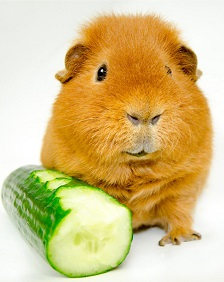

In [10]:
transform = make_transform()
reverse_transform = make_reverse_transform()
image = Image.open("/kaggle/input/sample-diffusion/guineapig_cucumber.jpg")
x = transform(image)
display(image)

In [11]:
def get_fashion_mnist(train_transform, test_transform) -> tuple[TensorDataset, TensorDataset]:
    """Return MNIST data using the provided Tensor class."""
    mnist_train = datasets.FashionMNIST("../data", train=True, download=True)
    mnist_test = datasets.FashionMNIST("../data", train=False)
    print("Preprocessing data...")
    train_tensors = TensorDataset(
        t.stack([train_transform(img) for (img, label) in tqdm(mnist_train, desc="Training data")])
    )
    test_tensors = TensorDataset(t.stack([test_transform(img) for (img, label) in tqdm(mnist_test, desc="Test data")]))
    return (train_tensors, test_tensors)

train_transform = Compose([ToTensor(), RandomHorizontalFlip(), Lambda(lambda t: t * 2 - 1)])
data_folder = Path("data/w3d4")
data_folder.mkdir(exist_ok=True, parents=True)
DATASET_FILENAME = data_folder / "generative_models_dataset_fashion.pt"
if DATASET_FILENAME.exists():
    (train_dataset, test_dataset) = t.load(str(DATASET_FILENAME))
else:
    (train_dataset, test_dataset) = get_fashion_mnist(train_transform, train_transform)
    t.save((train_dataset, test_dataset), str(DATASET_FILENAME))

100%|██████████| 26421880/26421880 [00:00<00:00, 116063522.01it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 4320335.12it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 60839262.58it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14973839.80it/s]


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

Preprocessing data...


Training data:   0%|          | 0/60000 [00:00<?, ?it/s]

Test data:   0%|          | 0/10000 [00:00<?, ?it/s]

In [12]:
config_dict: dict[str, Any] = dict(
    model_channels = 28,
    model_dim_mults = (1, 2, 4),
    image_shape = (1, 28, 28),
    max_steps = 200,
    epochs = 10,
    lr = 0.001,
    batch_size=128,
    img_log_interval=400,
    n_images_to_log=3,
    device=t.device("cuda") if t.cuda.is_available() else t.device("cpu"),
)
    
model = Unet(config_dict["image_shape"],
            config_dict["model_channels"],
            config_dict["model_dim_mults"],
            max_steps = config_dict["max_steps"])
MODEL_FILENAME = data_folder / "unet_model.pt"
print("Training model from scratch!")
model = train(model, config_dict, train_dataset, test_dataset)
t.save(model.state_dict(), str(MODEL_FILENAME))

Training model from scratch!


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Training with config: {'model_channels': 28, 'model_dim_mults': [1, 2, 4], 'image_shape': [1, 28, 28], 'max_steps': 200, 'epochs': 10, 'lr': 0.001, 'batch_size': 128, 'img_log_interval': 400, 'n_images_to_log': 3, 'device': 'cuda'}


Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Eval for Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

Eval for Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

Eval for Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

Eval for Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

Eval for Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/469 [00:00<?, ?it/s]

Eval for Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/469 [00:00<?, ?it/s]

Eval for Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/469 [00:00<?, ?it/s]

Eval for Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/469 [00:00<?, ?it/s]

Eval for Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/469 [00:00<?, ?it/s]

Eval for Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

elapsed,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eval_loss,█▅▃▃▂▂▂▂▂▁
noised_mean,▃▁▂▆▅▃▂▅▁▆█▂▆▇▄▃▄▄▁▄▂▅▅▂▁▂▅▄▄▃▂▆▆▂▇▃▂▃▃▇
noised_var,▂▂▃▅▂▆▃▇▁▄▅▂██▄▃▄▅▁▄▂█▇▁▃▄▂▄▅▄▄▇▆▃▇▂▃▂▂▇
train_loss,█▄▄▃▄▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▂▁▁▂▁▂▁▂▂▂▂▁
y_hat_mean,▄█▇▂▃▄▁▄▇▆▅▂▃▄▃▄▆▁▄▃▆▇▂▄▄▆▅▃▆▄▄▂█▄▇▄▃▄▃▆
y_hat_var,▁▇▅▅▅▅▆▇▆▆▆▆▆▇▆▆▆▆▆▇▆▇▆▆▇▆▆▇▆▇███▇▇▅▇▆▅▇
elapsed,542.69698
eval_loss,0.08603
noised_mean,-0.2877
noised_var,0.73758


  0%|          | 0/200 [00:00<?, ?it/s]

Generated images: 


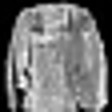

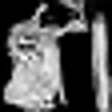

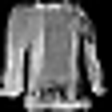

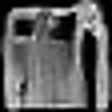

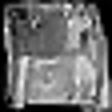

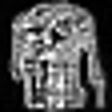

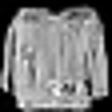

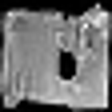

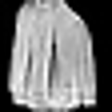

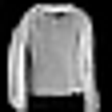

Training images: 


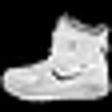

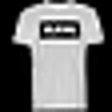

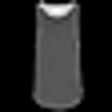

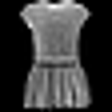

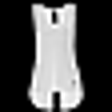

  0%|          | 0/200 [00:00<?, ?it/s]

Printing sequential denoising: 
Step  0


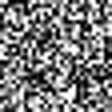

Step  10


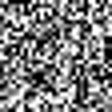

Step  20


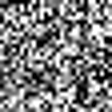

Step  30


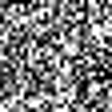

Step  40


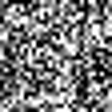

Step  50


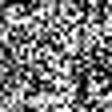

Step  60


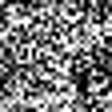

Step  70


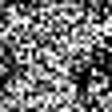

Step  80


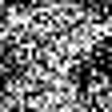

Step  90


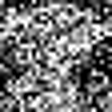

Step  100


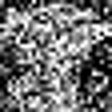

Step  110


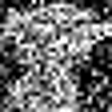

Step  120


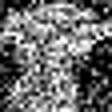

Step  130


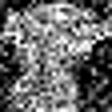

Step  140


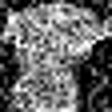

Step  150


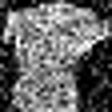

Step  160


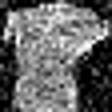

Step  170


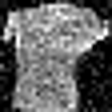

Step  180


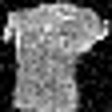

Step  190


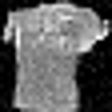

Step  200


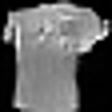

In [13]:
with t.inference_mode():
    samples = sample(model, n_samples = 10)
    
assert isinstance(samples, t.Tensor)
print("Generated images: ")
for s in samples:
    img = reverse_transform(s.cpu())
    display(img.resize((4 * 28, 4 * 28)))
print("Training images: ")
(xs,) = train_dataset[:5]
for x in xs:
    display(reverse_transform(x).resize((4 * 28, 4 * 28)))
    
with t.inference_mode():
    samples = sample(model, n_samples=1, return_all_steps=True)
print("Printing sequential denoising: ")
for (i, s) in enumerate(samples):
    if i % (len(samples) // 20) == 0:
        print("Step ", i)
        img = reverse_transform(s[0].cpu())
        display(img.resize((4 * 28, 4 * 28)))